<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
This is a notebook to describe the step by step logic of training a GP-VAE on dataset Sprites
</div>

VAEs dynamiques : https://arxiv.org/abs/2008.12595

Papiers GP-VAE :
- Deep Probabilistic Time Series Imputation https://arxiv.org/abs/1907.04155
- Gaussian Process Prior Variational Autoencoders : https://arxiv.org/abs/1810.11738
- Bayesian Gaussian Process Latent Variable Model : https://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf
- Markovian Gaussian Process Variational Autoencoders : https://arxiv.org/abs/2207.05543

Imports and set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from libs.load_sprites import sprites_act
import imageio.v2 as imageio

import timeit
from IPython.display import clear_output

In [2]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# print(f"Added {parent_dir} to Python path")
# print(f"Current working directory: {os.getcwd()}")
# print(f"Python path: {sys.path}")

In [3]:
# Set seed for reproducibility

def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Sprites dataset

In [5]:
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('data/sprites/', return_labels=True)

walk front 0 0 0
walk left 0 1 1
walk right 0 2 2
spellcard front 1 0 3
spellcard left 1 1 4
spellcard right 1 2 5
slash front 2 0 6
slash left 2 1 7
slash right 2 2 8
A_test.shape: (2664, 8, 4, 6), D_test.shape: (2664, 8, 9), X_test.shape: (2664, 8, 64, 64, 3)
X_train.shape: (9000, 8, 64, 64, 3), X_test.min(): 0.0, X_test.max(): 0.99609375
data loaded in 2.50 seconds...


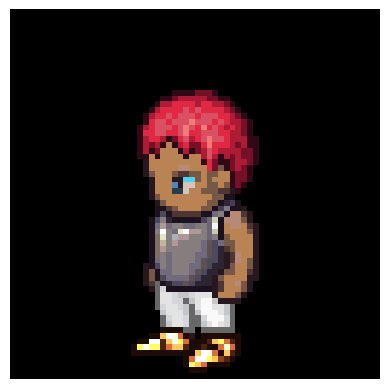

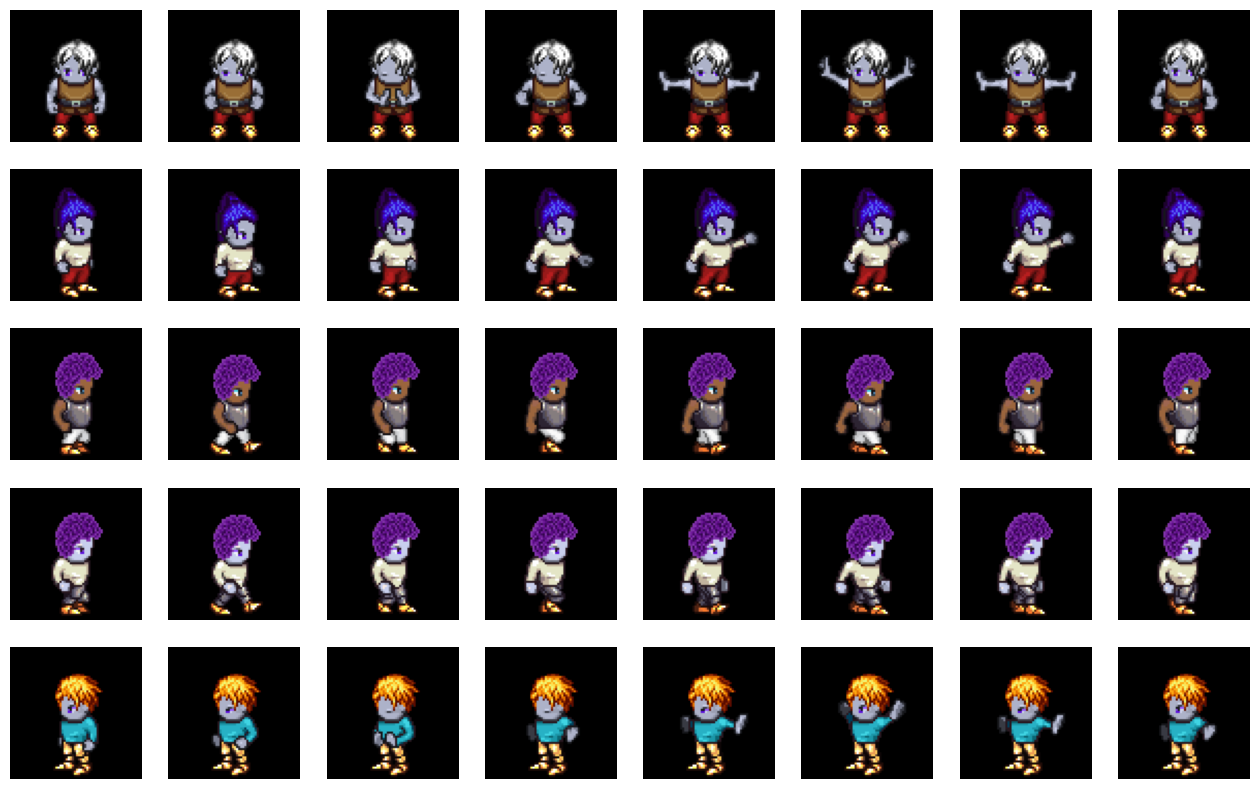

In [6]:
e = X_train[0,0,:]

plt.imshow(e)
plt.axis('off')
plt.show()

N = X_train.shape[0]
T = X_train.shape[1]
N_SAMPLES = 5

idx = np.random.choice(N, N_SAMPLES, replace=False)

fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=T, figsize=(T*2, N_SAMPLES*2))

for i, id_seq in enumerate(idx):
    images = X_train[id_seq]
    for t in range(T):
        ax[i, t].imshow(images[t])
        ax[i, t].axis('off')

Dataset / Dataloader

In [7]:
# form datasets and dataloaders for PyTorch training
class CSRDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]
    
train_dataset = CSRDataset(X_train)
test_dataset = CSRDataset(X_test)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 9000
Test dataset size: 2664


In [8]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [9]:
# check shape of outputs

train_iter = iter(train_loader)
x = next(train_iter).to(device)
print(f"loader shape : batch_size x 8 x 64 x 64 x 3 = {x.shape}")  # should be (batch_size, T, 64, 64, 3)

loader shape : batch_size x 8 x 64 x 64 x 3 = torch.Size([256, 8, 64, 64, 3])


# Parameters

In [10]:
# Dimension of the latent space
Dz = 4

# for encoder and decoder models
hidden_dim = 256

# Time stamps (B,T)
t = torch.linspace(0, 1, x.size()[1]).to(device).unsqueeze(0).repeat(batch_size, 1)

# Number of samples
K = 3

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Encoder
</div>

In [11]:
from libs.gpvae_lib_sprites import EncoderCNN

encoder = EncoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)

print(f"encoder input shape : (B,T,64,64,3) = {x.shape}")  # should be (batch_size, T, 64, 64, 3)

mu_x, logcovar_x = encoder(x.to(device))

print(
    f"encoder output shape :\n" \
    f"\tmean (B, T, Dz) = {mu_x.shape}\n" \
    f"\tlogcovar data (B,T,Dz) = {logcovar_x.shape}")  # should be (batch_size, T, Dz)

encoder input shape : (B,T,64,64,3) = torch.Size([256, 8, 64, 64, 3])
encoder output shape :
	mean (B, T, Dz) = torch.Size([256, 8, 4])
	logcovar data (B,T,Dz) = torch.Size([256, 8, 4])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Posterior
</div>

For a given time serie, the approximate posterior $q_{\phi}$ is a set of $D_z$ independent -but not identical- multivariate Gaussians of dimension $N$. 

This encodes a temporal dependency over each dimension of the latent variables, but no dependency between dimensions.

$q_{\phi}$ is a tf.distribution.MultivariateNormal object with batch_shape = $(B, D_z)$ and event_shape = ($N$)

\begin{align}
q_{\phi}(z_{1:N} \vert x_{1:N}) &= \mathcal{N}(\mu_{\phi}(z_{1:N} \vert x_{1:N}), \Sigma_{\phi}(z_{1:N} \vert x_{1:N}))
\end{align}

Here we compute

\begin{align}
q_{\phi}(z_{1:N} \vert x_{1:N}) &= \mathcal{N}(\mu_{\phi}(z_{1:N} \vert x_{1:N}), \text{diag} \,\, \sigma_{\phi}^{2}(z_{1:N} \vert x_{1:N}))
\end{align}

In [12]:
# we compute a posterior over Dz independent multivariate Gaussians of dimension T
mu_phi = mu_x.permute(0,2,1)  # (B, Dz, T)

# assume diagonal covariance matrices for each of the Dz independent Gaussians here
covar_phi = torch.diag_embed(torch.exp(logcovar_x).permute(0,2,1))  # (B, Dz, T, T) diagonal matrices

q_phi = torch.distributions.MultivariateNormal(loc=mu_phi, covariance_matrix=covar_phi)

print(f"q_phi mean shape : (B,Dz,T) = {q_phi.mean.shape}")  # should be (batch_size, Dz, T)
print(f"q_phi covar shape : (B,Dz,T,T) = {q_phi.covariance_matrix.shape}")  # should be (batch_size, Dz, T, T)
print(f"q_phi batch shape : (B,Dz) = {q_phi.batch_shape}")  # should be (batch_size,Dz)
print(f"q_phi event shape : (T) = {q_phi.event_shape}")  # should be (T)

q_phi mean shape : (B,Dz,T) = torch.Size([256, 4, 8])
q_phi covar shape : (B,Dz,T,T) = torch.Size([256, 4, 8, 8])
q_phi batch shape : (B,Dz) = torch.Size([256, 4])
q_phi event shape : (T) = torch.Size([8])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Gaussian Process priors
</div>

Each dimension $l$ of the latent variables (with $1 \leq l \leq D_z$) has a Gaussian Process prior over times:

\begin{align}
z_l \sim \mathcal{GP}(m_l(.), k_l(.,.))
\end{align}

The mean functions $m_l$ are usually constant null.

The kernel functions $k_l(.,.)$ are a priori different along the dimensions. They encode the prior knowledge (if any) regarding the time series. They can either be fixed, or have learnable parameters.

In [13]:
from libs.gpvae_lib_sprites import GaussianKernel, GaussianKernelFixed, MaternKernel, MaternKernelFixed, GPNullMean, GPConstantMean

In [14]:
# need to form two lists of Dz kernel and mean functions (one per latent dimension)
# can be handcrafted or built

kernels_list = [ MaternKernelFixed(nu=1.5, lengthscale=1.0, sigma=1.0).to(device) for _ in range(Dz) ]  # list of Dz identical kernels
mean_functions_list = [ GPNullMean().to(device) for _ in range(Dz) ]  # list of Dz identical mean functions

In [15]:
from libs.gpvae_lib_sprites import compute_gp_priors

In [16]:
mean, kernel_matrix, L_matrix, p_theta_z = compute_gp_priors(t, Dz, kernels_list, mean_functions_list, verbose=True)


Computing Gaussian Process prior for z component 1 / 4...
Kernel 0 is : MaternKernelFixed(nu=1.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 0 is : GPNullMean
mu_z 0 shape (B,N): torch.Size([256, 8])
Kernel matrix 0 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component 2 / 4...
Kernel 1 is : MaternKernelFixed(nu=1.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 1 is : GPNullMean
mu_z 1 shape (B,N): torch.Size([256, 8])
Kernel matrix 1 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component 3 / 4...
Kernel 2 is : MaternKernelFixed(nu=1.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 2 is : GPNullMean
mu_z 2 shape (B,N): torch.Size([256, 8])
Kernel matrix 2 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Sampling from posterior
</div>

We sample $K$ samples from $q_{\phi}$

In [17]:
z_samples = q_phi.rsample(sample_shape=(K,))  # (K, B, Dz, T)
print(f"z_samples shape : (K,B,Dz,T) = {z_samples.shape}")  # should be (K, batch_size, Dz, T)

z_samples shape : (K,B,Dz,T) = torch.Size([3, 256, 4, 8])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Decoder
</div>

By D-separation, we know that the decoder factorizes :

\begin{align}
p_{\theta_x}(x_{1:N} \vert z_{1:N}) &= \prod_{i=1}^{N} p_{\theta_x}(x_i \vert z_i)
\end{align}

We build a decoder with an inverse CNN.

In [18]:
from libs.gpvae_lib_sprites import DecoderCNN

decoder = DecoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)
x_recon = decoder(z_samples.permute(0,1,3,2))  # (K,B,T,W=64,H=64,C=3)

print(f"x_recon shape : (K,B,T,W=64,H=64,C=3) = {x_recon.shape}")  # should be (K, batch_size, T, 64, 64, 3)

x_recon shape : (K,B,T,W=64,H=64,C=3) = torch.Size([3, 256, 8, 64, 64, 3])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Computing the loss
</div>

The loss is

\begin{align}
\mathcal{L}(\theta_x, \theta_z, \phi, x_{1:N}) &= \sum_{i=1}^N \mathbb{E}_{z_i \sim q_{\phi}(z_i \vert x_{1:N})} \log{p_{\theta_x}(x_i \vert z_i)} - \sum_{l=1}^{D_z} \mathbb{KL} ( q_{\phi}(z_l \vert x_{1:N}) \vert\vert p_{\theta_z}(z_{l,1:N})) 
\end{align}

Where the expectation $\mathbb{E}_{z_i \sim q_{\phi}(z_i \vert x_{1:N})}$ is approximated by averaging $K$ $p_{\theta_x}$ samples, and the $\mathbb{KL}$'s are computed analytically for two Gaussians.

Remember that $p_{\theta_x}$ is a tf.distributions.MVN object of batch_shape $(K,B,N)$ and event_shape $D_x$. We adapt the original data $x$ of shape $(B,N,Dx)$ accordingly.

In [19]:
# we start with the KL

kl = torch.distributions.kl_divergence(q_phi, p_theta_z)  # (B, Dz)
print(f"KL between q_phi and p_theta_z tensor shape : (B,Dz) = {kl.shape}")  # should be (batch_size, Dz)

KL between q_phi and p_theta_z tensor shape : (B,Dz) = torch.Size([256, 4])


In [20]:
# and then the reconstruction loss

print(f"Input x : shape : (B,T,64,64,3) = {x.shape}")  # should be (batch_size, T, 64, 64, 3)
print(f"x min : {x.min().item():.4f}, x_max : {x.max().item():.4f}")
print(f"Reconstructed x_recon : shape : (K,B,T,64,64,3) = {x_recon.shape}")  # should be (K, batch_size, T, 64, 64, 3)
print(f"x_recon min : {x_recon.min().item():.4f}, x_recon max : {x_recon.max().item():.4f}")

reconstruction_error = (x - x_recon)**2  # (K,B,T,64,64,3)
print()
print(f"reconstruction_error tensor shape : (K,B,T,64,64,3) = {reconstruction_error.shape}")  # should be (K, batch_size, T, 64, 64, 3)

Input x : shape : (B,T,64,64,3) = torch.Size([256, 8, 64, 64, 3])
x min : 0.0000, x_max : 0.9961
Reconstructed x_recon : shape : (K,B,T,64,64,3) = torch.Size([3, 256, 8, 64, 64, 3])
x_recon min : 0.4240, x_recon max : 0.5815

reconstruction_error tensor shape : (K,B,T,64,64,3) = torch.Size([3, 256, 8, 64, 64, 3])


In [21]:
loss = -reconstruction_error.mean() + kl.mean()
print(f"loss : {loss.item():.4f}")

loss.backward()  # backpropagate the loss

loss : 452.1317


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Training
</div>

In [22]:
from libs.gpvae_lib_sprites import EarlyStoppingCallback
early_stopper = EarlyStoppingCallback(patience=30, min_delta=1e-3)

Assemble components

In [23]:
encoder = EncoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)
decoder = DecoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)

delta_t = 1.0  # time step between two frames if T=8 frames in [0,1]

kernels_list = [ MaternKernel(nu=2.5, lengthscale=1.0, sigma=1.0).to(device) for _ in range(Dz) ] # list of Dz identical kernels
mean_functions_list = [ GPNullMean().to(device) for _ in range(Dz) ] # list of Dz identical mean functions
mean, kernel_matrix, L_matrix, p_theta_z = compute_gp_priors(t, Dz, kernels_list, mean_functions_list, verbose=True)


Computing Gaussian Process prior for z component 1 / 4...
Kernel 0 is : MaternKernel(nu=2.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 0 is : GPNullMean
mu_z 0 shape (B,N): torch.Size([256, 8])
Kernel matrix 0 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component 2 / 4...
Kernel 1 is : MaternKernel(nu=2.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 1 is : GPNullMean
mu_z 1 shape (B,N): torch.Size([256, 8])
Kernel matrix 1 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component 3 / 4...
Kernel 2 is : MaternKernel(nu=2.5, lengthscale=1.000e+00, sigma=1.000e+00, variance (sigma**2)=1.000e+00, epsilon=1.000e-03)
Mean function 2 is : GPNullMean
mu_z 2 shape (B,N): torch.Size([256, 8])
Kernel matrix 2 shape (B,N,N): torch.Size([256, 8, 8])

Computing Gaussian Process prior for z component 4 / 4...
Kerne

Form parameters from the kernels and mean functions, if they are learnable, form the optimizer

In [24]:
from libs.gpvae_lib_sprites import get_parameters_from_priors

prior_params = get_parameters_from_priors(kernels_list, mean_functions_list)

if prior_params:
    learnable_prior = True
else:
    learnable_prior = False
    
print(f"Learnable prior : {learnable_prior}")

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + prior_params,
    lr = 1e-3
)

Learnable prior : True


In [25]:
from libs.gpvae_lib_sprites import train_step, test_step

In [26]:
def train(
    train_loader,
    test_loader,
    encoder,
    decoder,
    optimizer,  
    prior,
    learnable_prior,
    device,
    K,  
    n_epochs=100,
):
    # log
    train_losses = []
    test_losses = []
    train_kls = []
    test_kls = []
    train_rec_losses = []
    test_rec_losses = []
    
    # early stopping
    msg = "no callback"
    
    # train the model for n_epochs epochs
    for epoch in range(n_epochs):
        
        # PRIOR pass --------------------------------------------------------------
        # if the kernel is learnable, we need to recompute the prior mean and kernel at each epoch
        if learnable_prior:
            mean, kernel_matrix, L_matrix, prior = compute_gp_priors(t, Dz, kernels_list, mean_functions_list, verbose=False)
            
        # One train step
        encoder, decoder, train_epoch_loss, train_epoch_kl, train_epoch_rec_loss = train_step(
            train_loader,
            encoder,
            decoder,
            optimizer,  
            prior,
            device,
            K,
        )
        
        train_losses.append(train_epoch_loss)
        train_kls.append(train_epoch_kl)
        train_rec_losses.append(train_epoch_rec_loss)
        
        # One test step
        test_epoch_loss, test_epoch_kl, test_epoch_rec_loss = test_step(
            test_loader,
            encoder,
            decoder,
            prior,
            device,
            K,
        )
        
        test_losses.append(test_epoch_loss)
        test_kls.append(test_epoch_kl)
        test_rec_losses.append(test_epoch_rec_loss)
        
        # Early stopping check
        if early_stopper:
            stop, counter = early_stopper.early_stop(test_epoch_loss)
            if stop:
                msg = f'Early stopping at epoch {epoch+1} with counter {counter}'
                stop = True
            else:
                msg = f'Early stopping counter: {counter} / {early_stopper.patience}'
        
        # report out
        print(f"Epoch {epoch+1:<6} / {n_epochs:<6} - TRAIN : total loss {train_epoch_loss:.4e}, KL: {train_epoch_kl:.4e}, Reco: {train_epoch_rec_loss:.4e} -- TEST : total loss {test_epoch_loss:.4e}, KL: {test_epoch_kl:.4e}, Reco: {test_epoch_rec_loss:.4e} -- {msg}")
        
        # check overfit
        if stop:
            print("Early stopping triggered. Stopping training.")
            break
        
    return train_losses, test_losses, train_kls, test_kls, train_rec_losses, test_rec_losses

In [27]:
# debug
# torch.autograd.set_detect_anomaly(True)

mean, kernel_matrix, L_matrix, prior = compute_gp_priors(t, Dz, kernels_list, mean_functions_list, verbose=False)

train_losses, test_losses, train_kls, test_kls, train_rec_losses, test_rec_losses = train(
    train_loader,
    test_loader,
    encoder,
    decoder,
    optimizer,  
    prior,
    learnable_prior,
    device,
    K,  
    n_epochs=50,
)

Epoch 1      / 50     - TRAIN : total loss 1.3718e+02, KL: 1.3709e+02, Reco: 1.3718e+02 -- TEST : total loss 1.1795e+01, KL: 1.1763e+01, Reco: 3.2204e-02 -- Early stopping counter: 0 / 30
Epoch 2      / 50     - TRAIN : total loss 9.4386e+00, KL: 9.4086e+00, Reco: 9.4394e+00 -- TEST : total loss 8.4705e+00, KL: 8.4421e+00, Reco: 2.8449e-02 -- Early stopping counter: 0 / 30
Epoch 3      / 50     - TRAIN : total loss 8.4460e+00, KL: 8.4185e+00, Reco: 8.4468e+00 -- TEST : total loss 8.4129e+00, KL: 8.3864e+00, Reco: 2.6451e-02 -- Early stopping counter: 0 / 30
Epoch 4      / 50     - TRAIN : total loss 8.3840e+00, KL: 8.3583e+00, Reco: 8.3847e+00 -- TEST : total loss 8.3701e+00, KL: 8.3451e+00, Reco: 2.4969e-02 -- Early stopping counter: 0 / 30
Epoch 5      / 50     - TRAIN : total loss 8.3465e+00, KL: 8.3218e+00, Reco: 8.3472e+00 -- TEST : total loss 8.3362e+00, KL: 8.3118e+00, Reco: 2.4412e-02 -- Early stopping counter: 0 / 30
Epoch 6      / 50     - TRAIN : total loss 8.3075e+00, KL: 8

Plot losses

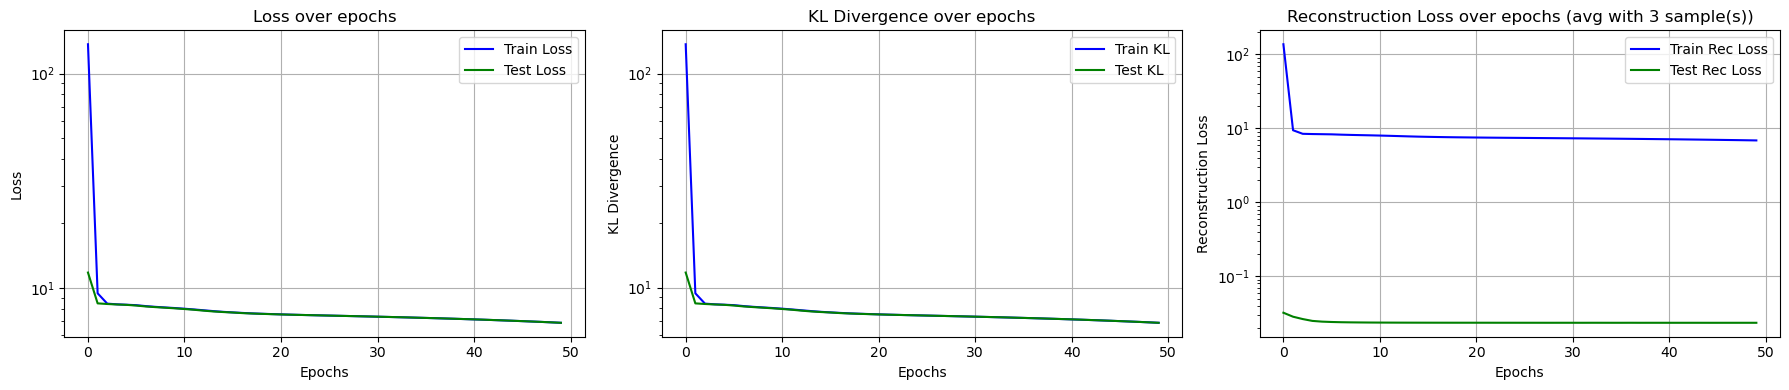

In [28]:
from libs.gpvae_lib_sprites import report_out_losses

report_out_losses(train_losses, test_losses, train_kls, test_kls, train_rec_losses, test_rec_losses, K)
plt.show()

Save models

In [29]:
# print(f"Getting models with latent dimension: {Dz}")
# dim = f"{Dz}"

# # load trained models
# path = 'models/'

# # save models
# torch.save(encoder.state_dict(), path + f'gpvae_encoder_sprites_{dim}.pth')
# torch.save(decoder.state_dict(), path + f'gpvae_decoder_sprites_{dim}.pth')

Load models id required

In [30]:
# print(f"Getting models with latent dimension: {Dz}")
# dim = f"{Dz}"

# # load trained models
# path = 'models/'

# encoder = EncoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)
# decoder = DecoderCNN(Dz=Dz, hidden_dim=hidden_dim).to(device)

# with open(path + f'gpvae_encoder_sprites_{dim}.pth', 'rb') as f:
#     encoder.load_state_dict(torch.load(f))
# with open(path + f'gpvae_decoder_sprites_{dim}.pth', 'rb') as f:
#     decoder.load_state_dict(torch.load(f))

Check reconstruction

In [31]:
N_SAMPLES = 3

# get samples from test set
idx = np.random.choice(len(X_test), N_SAMPLES, replace=False)
x_tests = X_test[idx]  # (N_SAMPLES, 8, 64, 64, 3)

# compute posterior
mu_x, logcovar_x = encoder(torch.tensor(x_tests, dtype=torch.float32).to(device))
mu_phi = mu_x.permute(0,2,1)  # (N_SAMPLES, Dz, T)
covar_phi = torch.diag_embed(torch.exp(logcovar_x).permute(0,2,1))  # (N_SAMPLES, Dz, T, T) diagonal matrices
q_phi = torch.distributions.MultivariateNormal(loc=mu_phi, covariance_matrix=covar_phi)

# set K
K = 3

# sample from posterior
z_samples = q_phi.rsample(sample_shape=(K,))  # (K, N_SAMPLES, Dz, T)

# decode
x_recon = decoder(z_samples.permute(0,1,3,2))  # (K, N_SAMPLES, T, 64, 64, 3)

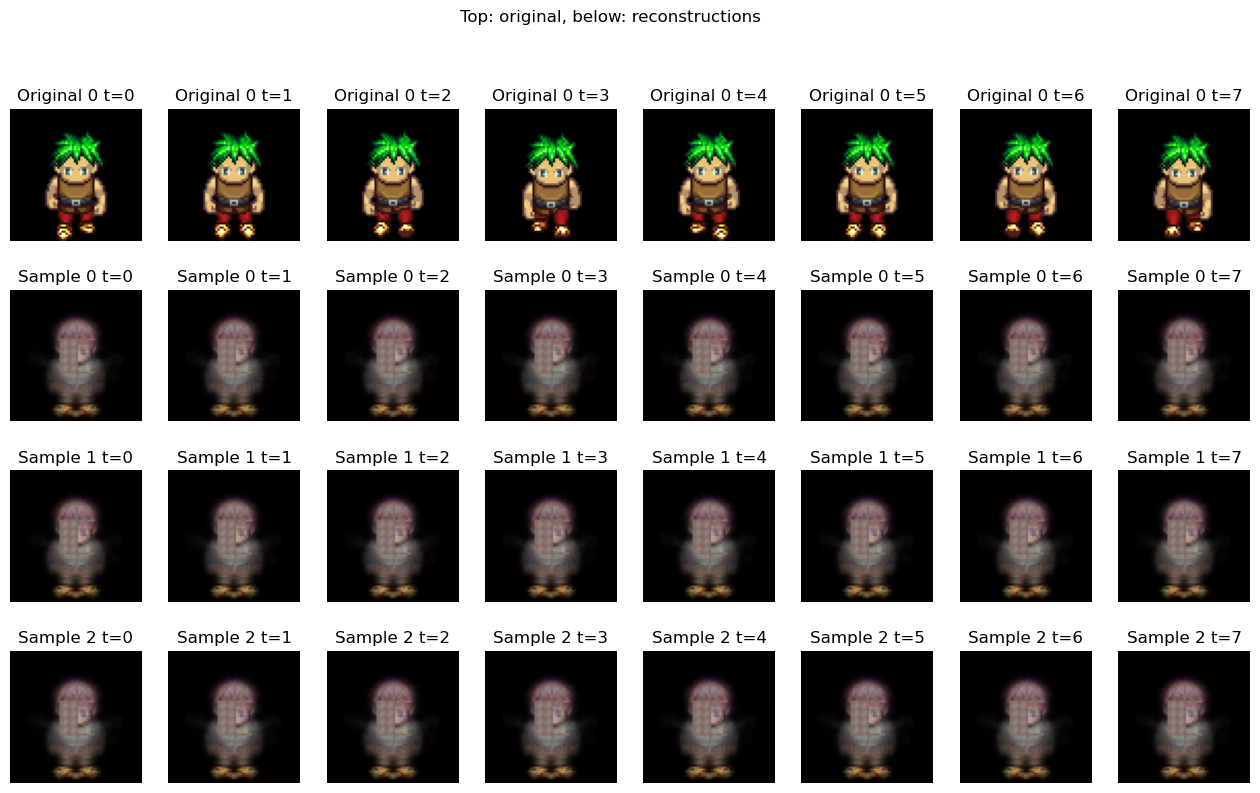

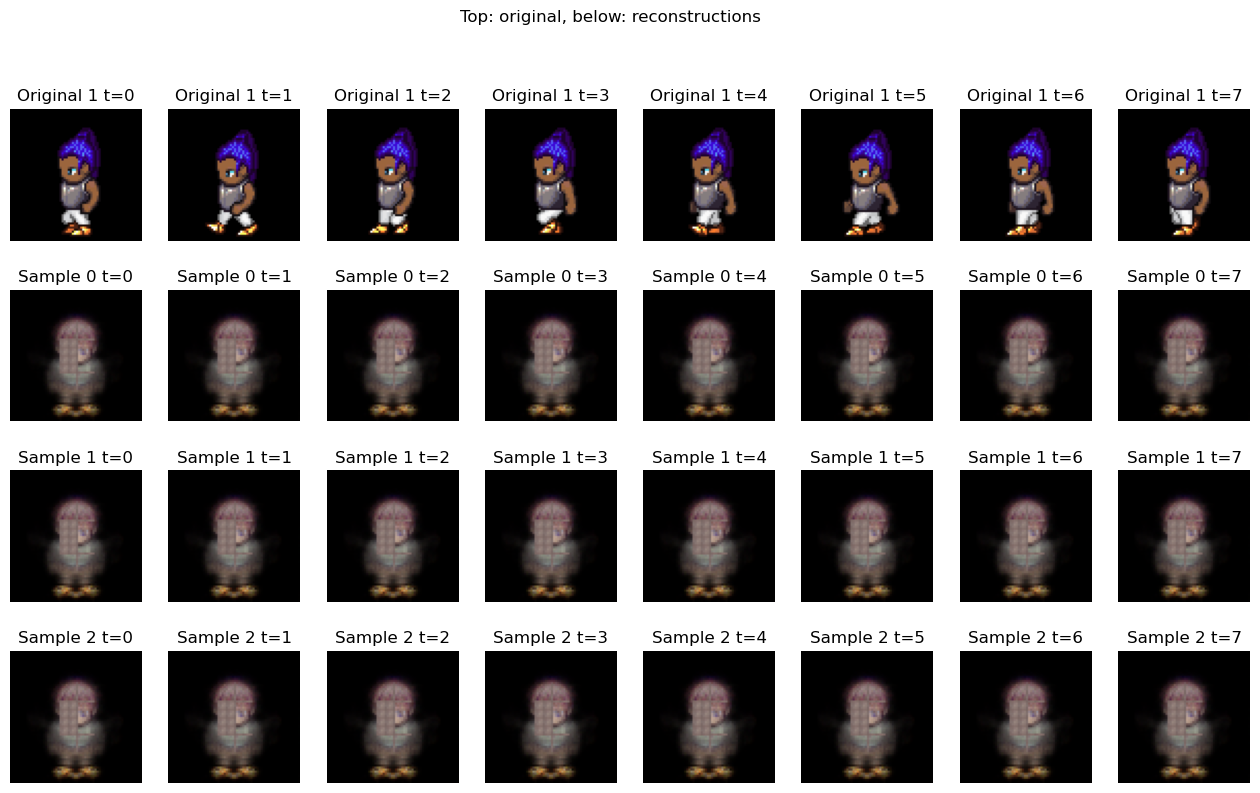

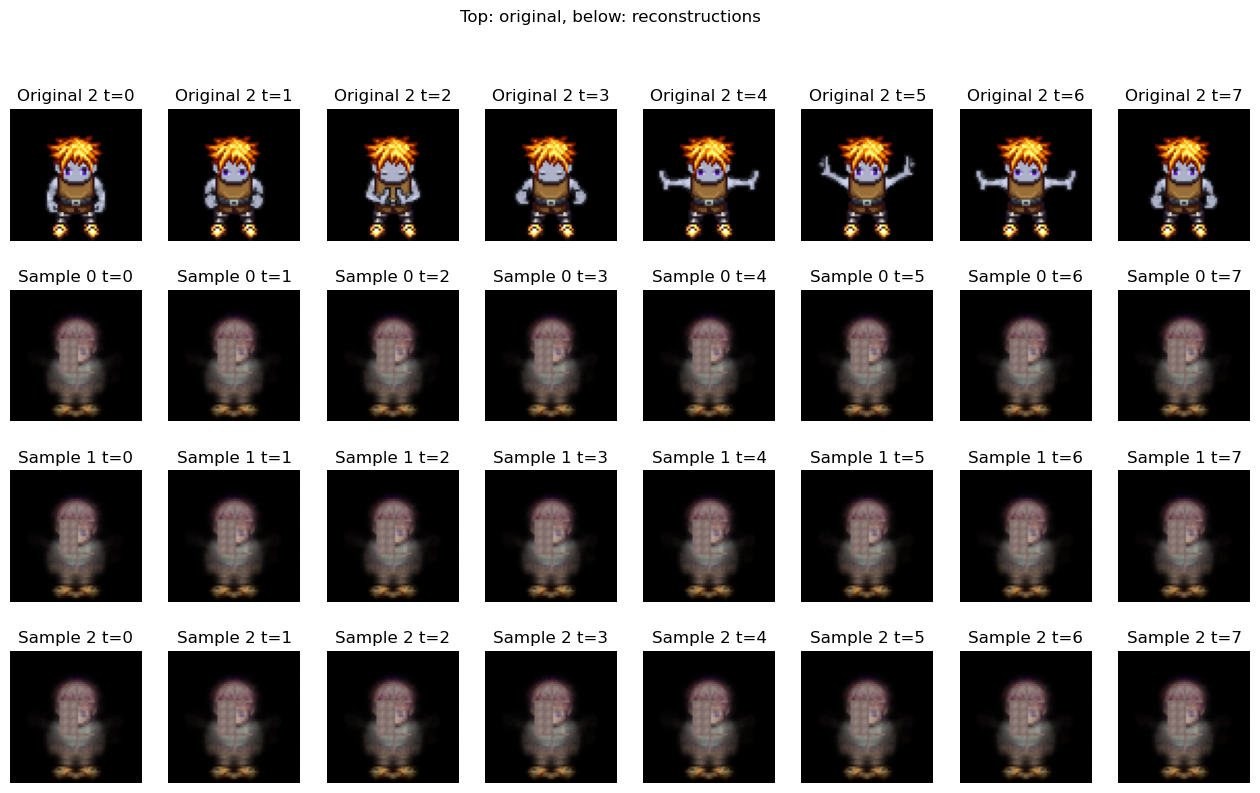

In [32]:
# display reconstructions

for i in range(N_SAMPLES):
    fig, ax = plt.subplots(nrows=(K+1), ncols=T, figsize=(T*2, K*3))
    for t in range(T):
        ax[0, t].imshow(x_tests[i,t])
        ax[0, t].axis('off')
        ax[0, t].set_title(f"Original {i} t={t}")
    for k in range(K):
        for t in range(T):
            ax[k+1, t].imshow(x_recon[k,i,t].detach().cpu().numpy())
            ax[k+1, t].axis('off')
            ax[k+1, t].set_title(f"Sample {k} t={t}")
    fig.suptitle("Top: original, below: reconstructions")
    
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Générations
</div>